![Logo BV IBMEC](https://raw.githubusercontent.com/ian-iania/IBMEC-BV-Modelos-Preditivos/main/logo-bv-ibmec-notebooks.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ian-iania/IBMEC-BV-Modelos-Preditivos/blob/main/notebooks/NB02_Classification.ipynb)

# NB02 — Classificação: Default PF 30+ (FP&A Banco BV)

**Objetivo da aula (walkthrough):**
- prever **P(default 30+)** para apoiar decisão de crédito
- entender **AUC/ROC** (separação), **cutoff** (decisão) e **custo em R$** (impacto)
- comparar **Logística vs Árvore vs GBM** com validação temporal


## 1) Setup e Contexto (FP&A)

Em classificação, o modelo prevê **probabilidade** de inadimplência (`P(default)`), não uma decisão final sozinho.

No dia a dia de FP&A, separamos 3 camadas:
- **Modelo**: quão bem separa bons e maus (AUC/ROC)
- **Política**: onde cortar a probabilidade (cutoff)
- **Resultado econômico**: custo/benefício em R$

### Mapa rápido deste notebook
1. Carregar e entender dados
2. Split temporal (treino/teste)
3. Métricas 101 (AUC, cutoff, matriz de confusão, custo)
4. Comparar 3 modelos de classificação
5. Demo executiva: tabela cutoff x custo total


### 1.1) Imports da aula

**O que vamos fazer:** carregar bibliotecas para dados, modelagem e gráficos.

**Por que importa em FP&A:** vamos transformar uma base de risco em métricas de decisão.

**O que observar no output:** uma confirmação simples de que o ambiente está pronto.


In [1]:
import pandas as pd  # biblioteca principal para carregar e manipular tabelas (DataFrame)
import numpy as np  # biblioteca para cálculos numéricos
import matplotlib.pyplot as plt  # biblioteca para criar gráficos da aula

from sklearn.compose import ColumnTransformer  # aplica tratamentos diferentes por tipo de coluna
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # codifica categóricas e padroniza numéricas
from sklearn.pipeline import Pipeline  # organiza pré-processamento + modelo em fluxo único

from sklearn.linear_model import LogisticRegression  # modelo linear para classificação
from sklearn.tree import DecisionTreeClassifier  # árvore de decisão para classificação
from sklearn.ensemble import GradientBoostingClassifier  # boosting para capturar padrões não lineares

from sklearn.metrics import (  # métricas de classificação e gráficos de avaliação
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)


### 1.2) Configuração visual e semente

**O que vamos fazer:** padronizar saída e reprodutibilidade.

**Por que importa em FP&A:** facilita comparar resultados em sala e no material depois.

**O que observar no output:** confirmação da semente fixa.


In [2]:
np.random.seed(42)  # fixa aleatoriedade para repetir os mesmos resultados
pd.set_option('display.max_columns', 60)  # mostra mais colunas em tabelas no notebook
pd.set_option('display.width', 140)  # amplia largura de impressão das tabelas

print('Ambiente configurado com seed = 42')  # mensagem de confirmação


Ambiente configurado com seed = 42


## 2) Carregar e entender o dataset (sanidade)

Vamos usar a base sintética de **default PF 30+** via URL raw do GitHub.

> Em último caso (se internet cair), o professor pode fazer upload manual no Colab.


### 2.1) Carregar CSV do GitHub raw

**O que vamos fazer:** abrir a base principal da aula.

**Por que importa em FP&A:** todos usam exatamente o mesmo dado, sem divergência de versão.

**O que observar no output:** origem dos dados e quantidade de linhas/colunas.


In [3]:
url = 'https://raw.githubusercontent.com/ian-iania/IBMEC-BV-Modelos-Preditivos/main/data/bv_pf_default30_sintetico.csv'  # URL oficial da base no GitHub
local_candidates = [  # caminhos de fallback para execução local (não usados em aula no Colab)
    '../data/bv_pf_default30_sintetico.csv',
    'data/bv_pf_default30_sintetico.csv',
]

try:
    df = pd.read_csv(url)  # tenta carregar direto da internet (fluxo principal da aula)
    fonte = 'GitHub raw'  # registra origem para conferência
except Exception as erro:
    df = None  # inicia como vazio para tentar fallback local
    fonte = f'Falha no raw ({erro})'  # guarda motivo da falha
    for caminho in local_candidates:
        try:
            df = pd.read_csv(caminho)  # tenta caminho local para testes fora do Colab
            fonte = f'Arquivo local: {caminho}'  # atualiza origem quando encontra
            break
        except Exception:
            pass
    if df is None:
        raise RuntimeError('Nao foi possivel carregar o dataset nem pela URL nem localmente.')

print('Fonte dos dados:', fonte)  # mostra de onde os dados vieram
print('Shape inicial:', df.shape)  # mostra total de linhas e colunas


Fonte dos dados: Arquivo local: data/bv_pf_default30_sintetico.csv
Shape inicial: (30000, 20)


### 2.2) Primeiras linhas (`head`)

**O que observar:** estrutura geral, nomes de colunas e exemplos de valores.


In [4]:
df.head(8)  # exibe as 8 primeiras linhas para inspeção inicial


,id,dt,selic,idade,renda_mensal,score_interno,valor_solicitado,prazo_meses,canal,utilizacao_limite,atraso_antes_30d,atraso_antes_60d,taxa_mensal,parcela_mensal,pti,default_30p,ead,lgd,loss_if_default,profit_if_good
0,1,2019-01-01,8.545462,23,4133.796015,776,7196.484870,48,agencia,0.172912,0,0,0.009198,153.236287,0.050000,0,5037.539409,0.583379,2938.795183,529.523098
1,2,2019-01-01,8.294674,47,4178.308983,773,11717.921205,24,digital,0.461099,0,0,0.008690,493.338026,0.118071,0,8202.544844,0.587916,4822.410658,407.304742
2,3,2019-01-01,8.188686,36,5322.488378,772,30678.668987,36,agencia,0.443791,1,0,0.014445,874.342850,0.164273,0,21475.068291,0.601346,12913.937890,2658.911983
3,4,2019-01-01,8.971483,62,3361.494336,823,13288.985806,48,digital,0.805487,0,0,0.011265,284.338962,0.084587,0,9302.290064,0.366524,3409.512481,1197.614528
4,5,2019-01-01,8.788261,37,23212.855803,680,20545.475032,24,agencia,0.267759,0,0,0.014140,870.586921,0.050000,0,14381.832522,0.325167,4676.503891,1162.036875
5,6,2019-01-01,8.981705,68,7600.026783,642,23010.319145,24,agencia,0.401419,0,0,0.012570,973.225100,0.128055,0,16107.223402,0.564561,9093.516231,1156.944183
6,7,2019-01-01,8.570394,65,4682.237329,752,20542.040545,36,agencia,0.915107,0,0,0.011446,582.368784,0.124378,0,14379.428381,0.478877,6885.977324,1410.785553
7,8,2019-01-01,8.429328,53,4148.379210,621,15666.277316,24,digital,0.836055,0,1,0.022712,670.552208,0.161642,0,10966.394121,0.595146,6526.607745,1423.252262


### 2.3) Lista de colunas

**Por que importa:** entender o dicionário da base evita erros no restante da aula.


In [5]:
print('Total de colunas:', len(df.columns))  # informa quantas colunas existem
print(list(df.columns))  # imprime os nomes das colunas em formato de lista


Total de colunas: 20
['id', 'dt', 'selic', 'idade', 'renda_mensal', 'score_interno', 'valor_solicitado', 'prazo_meses', 'canal', 'utilizacao_limite', 'atraso_antes_30d', 'atraso_antes_60d', 'taxa_mensal', 'parcela_mensal', 'pti', 'default_30p', 'ead', 'lgd', 'loss_if_default', 'profit_if_good']


### 2.4) Tipos de dados (`dtypes`)

**O que observar:** texto, número inteiro, número decimal e datas.


In [6]:
df.dtypes  # mostra o tipo de cada coluna para garantir que a leitura veio correta


id                     int64
dt                       str
selic                float64
idade                  int64
renda_mensal         float64
score_interno          int64
valor_solicitado     float64
prazo_meses            int64
canal                    str
utilizacao_limite    float64
atraso_antes_30d       int64
atraso_antes_60d       int64
taxa_mensal          float64
parcela_mensal       float64
pti                  float64
default_30p            int64
ead                  float64
lgd                  float64
loss_if_default      float64
profit_if_good       float64
dtype: object

### 2.5) Preparar coluna de data e ordenar no tempo

**O que vamos fazer:** converter `dt` para data real, ordenar cronologicamente e criar `mes_num`.

**Por que importa em FP&A:** split temporal só funciona corretamente se a série estiver em ordem.

**O que observar:** primeiras e últimas datas após ordenação.


In [7]:
df['dt'] = pd.to_datetime(df['dt'])  # converte texto de data para datetime
df = df.sort_values('dt').reset_index(drop=True)  # ordena no tempo e reseta índice

df['mes_num'] = df['dt'].dt.month  # cria número do mês (1..12) para capturar sazonalidade

print('Data mínima:', df['dt'].min().date())  # mostra início da série
print('Data máxima:', df['dt'].max().date())  # mostra fim da série


Data mínima: 2019-01-01
Data máxima: 2024-12-31


### 2.6) Taxa de default da base

**O que observar:** proporção média da classe `default_30p`.

Esse número ajuda a entender desbalanceamento da classificação.


In [8]:
taxa_default = df['default_30p'].mean()  # calcula média da variável alvo (0/1)
print(f'Taxa de default (base completa): {taxa_default:.2%}')  # imprime percentual formatado


Taxa de default (base completa): 8.60%


### 2.7) Estatísticas rápidas das variáveis-chave

**O que observar:** faixa e dispersão de `selic`, `pti`, `score_interno`, `loss_if_default`, `profit_if_good`.


In [9]:
colunas_stats = ['selic', 'pti', 'score_interno', 'loss_if_default', 'profit_if_good']  # seleciona colunas para resumo

df[colunas_stats].describe().T  # mostra estatísticas descritivas em formato de tabela transposta


,count,mean,std,min,25%,50%,75%,max
selic,30000.0,8.793403,1.157024,5.641976,7.909602,8.825308,9.683758,12.241445
pti,30000.0,0.171640,0.165329,0.050000,0.055443,0.108959,0.213383,0.800000
score_interno,30000.0,669.339233,110.028876,300.000000,595.000000,669.000000,744.000000,950.000000
loss_if_default,30000.0,7658.427511,5362.641860,427.995870,3775.834063,6296.596119,10067.526326,44800.000000
profit_if_good,30000.0,1522.009448,1433.528617,150.000000,576.716967,1085.585359,1982.713701,12000.000000


### 2.8) Plot: taxa de default (classe desbalanceada)

**Por que importa:** em classificação de crédito, quase sempre a classe de default é minoritária.

**O que observar:** comparação visual entre `% Não default` e `% Default`.


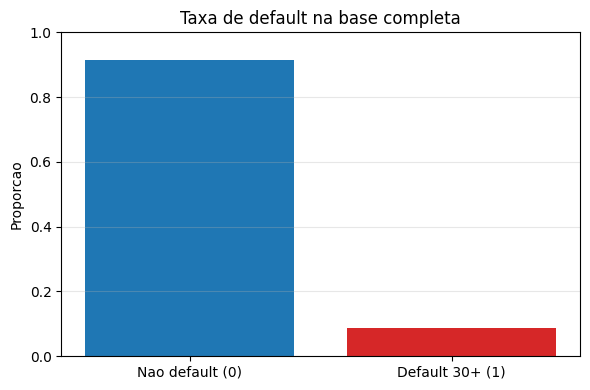

In [10]:
proporcoes = df['default_30p'].value_counts(normalize=True).sort_index()  # calcula participação das classes
labels = ['Nao default (0)', 'Default 30+ (1)']  # define nomes das classes no gráfico

plt.figure(figsize=(6, 4))  # cria figura
plt.bar(labels, proporcoes.values, color=['#1f77b4', '#d62728'])  # plota barras de proporção por classe
plt.title('Taxa de default na base completa')  # título do gráfico
plt.ylabel('Proporcao')  # rótulo do eixo Y
plt.ylim(0, 1)  # fixa escala de 0 a 1 para leitura percentual
plt.grid(axis='y', alpha=0.3)  # adiciona grade horizontal para facilitar comparação
plt.tight_layout()  # ajusta margens
plt.show()  # renderiza gráfico


Leitura FP&A: se a barra de default for bem menor, o problema é desbalanceado e o cutoff ganha importância.


### 2.9) Plot: histograma de `pti`

**Por que importa:** PTI alto tende a aumentar risco de inadimplência.

**O que observar:** concentração da distribuição e presença de cauda.


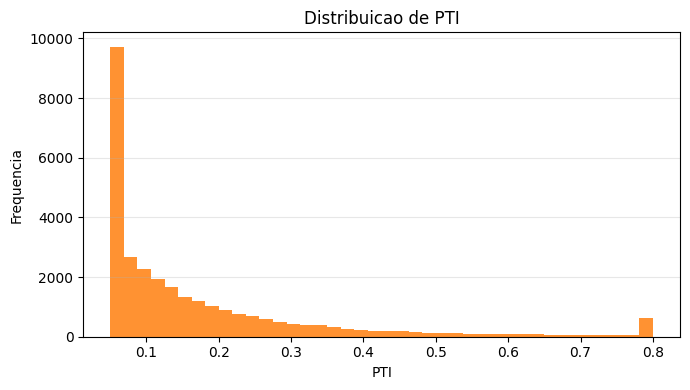

In [11]:
plt.figure(figsize=(7, 4))  # cria figura do histograma de PTI
plt.hist(df['pti'], bins=40, color='#ff7f0e', alpha=0.85)  # plota distribuição de PTI
plt.title('Distribuicao de PTI')  # título
plt.xlabel('PTI')  # eixo X
plt.ylabel('Frequencia')  # eixo Y
plt.grid(axis='y', alpha=0.3)  # grade horizontal
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza


Leitura FP&A: esse gráfico ajuda a identificar faixa de PTI onde pode haver maior risco.


### 2.10) Plot: histograma de `score_interno`

**Por que importa:** score é um dos principais drivers de decisão de crédito.

**O que observar:** onde estão concentrados os clientes em score.


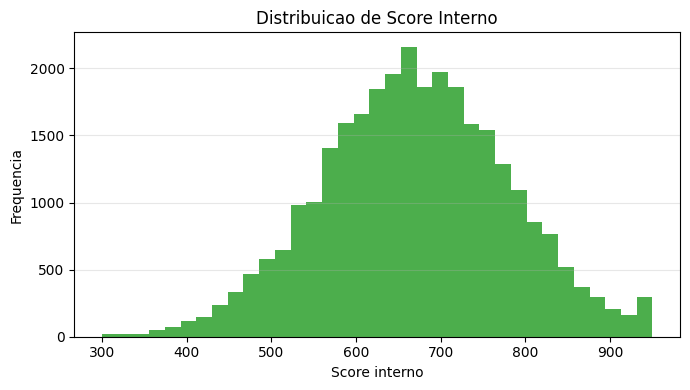

In [12]:
plt.figure(figsize=(7, 4))  # cria figura do histograma de score
plt.hist(df['score_interno'], bins=35, color='#2ca02c', alpha=0.85)  # plota distribuição de score
plt.title('Distribuicao de Score Interno')  # título
plt.xlabel('Score interno')  # eixo X
plt.ylabel('Frequencia')  # eixo Y
plt.grid(axis='y', alpha=0.3)  # grade horizontal
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza


Leitura FP&A: distribuição de score ajuda a calibrar expectativas sobre aprovação e risco.


### 2.11) Plot: SELIC média ao longo do tempo

**Por que importa:** macroeconomia pode deslocar risco da carteira no tempo.

**O que observar:** tendência da SELIC média mensal na base.


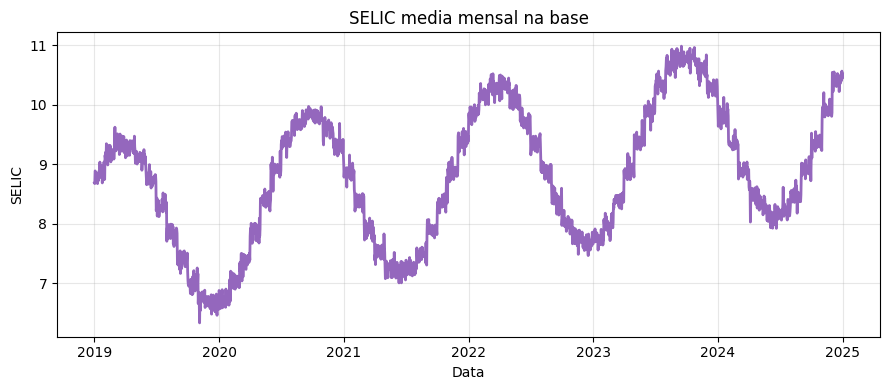

In [13]:
selic_mes = df.groupby('dt', as_index=False)['selic'].mean()  # agrega SELIC média por mês

plt.figure(figsize=(9, 4))  # cria figura da série temporal
plt.plot(selic_mes['dt'], selic_mes['selic'], color='#9467bd', linewidth=2)  # plota linha de SELIC no tempo
plt.title('SELIC media mensal na base')  # título
plt.xlabel('Data')  # eixo X
plt.ylabel('SELIC')  # eixo Y
plt.grid(alpha=0.3)  # grade
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza


Leitura FP&A: mudanças de SELIC podem alterar comportamento de default e desempenho de modelo.


## 3) Split temporal (Treino/Teste) — regra FP&A

Aqui vamos separar dados por tempo (80/20), sem embaralhar.

**Regra de negócio:** treinamos no passado e avaliamos no futuro.


### 3.1) Criar treino e teste no tempo

**O que observar:** quantidade de linhas em treino e teste.


In [14]:
split_idx = int(len(df) * 0.8)  # calcula ponto de corte de 80%
train = df.iloc[:split_idx].copy().reset_index(drop=True)  # define período de treino (passado)
test = df.iloc[split_idx:].copy().reset_index(drop=True)  # define período de teste (futuro)

print('Linhas treino:', len(train))  # imprime tamanho do treino
print('Linhas teste :', len(test))  # imprime tamanho do teste


Linhas treino: 24000
Linhas teste : 6000


### 3.2) Conferir janela de datas de treino e teste

**Por que importa:** confirma que o teste está no fim da série.


In [15]:
print('Treino:', train['dt'].min().date(), 'ate', train['dt'].max().date())  # mostra período do treino
print('Teste :', test['dt'].min().date(), 'ate', test['dt'].max().date())  # mostra período do teste


Treino: 2019-01-01 ate 2023-10-12
Teste : 2023-10-12 ate 2024-12-31


### 3.3) Taxa de default em treino vs teste

**O que observar:** se a taxa muda entre períodos, existe variação temporal relevante.


In [16]:
taxa_train = train['default_30p'].mean()  # calcula taxa média no treino
taxa_test = test['default_30p'].mean()  # calcula taxa média no teste

print(f'Default treino: {taxa_train:.2%}')  # imprime taxa de default do treino
print(f'Default teste : {taxa_test:.2%}')  # imprime taxa de default do teste


Default treino: 8.28%
Default teste : 9.88%


## 4) Métricas 101 (AUC, ROC, Cutoff e Custo)

Nesta parte, construímos intuição antes de comparar vários modelos.


### 4.1) Baseline probabilístico simples

**O que vamos fazer:** prever a mesma probabilidade para todos (taxa média de default no treino).

**Por que importa em FP&A:** baseline é referência mínima; sem baseline não há comparação justa.

**O que observar:** AUC perto de 0.5 (quase aleatório).


In [17]:
y_train = train['default_30p'].copy()  # define alvo do treino
y_test = test['default_30p'].copy()  # define alvo do teste

proba_baseline = np.repeat(y_train.mean(), len(test))  # cria probabilidade constante com taxa do treino
auc_baseline = roc_auc_score(y_test, proba_baseline)  # calcula AUC da baseline

print(f'Baseline - probabilidade constante: {y_train.mean():.4f}')  # mostra valor único previsto
print(f'Baseline - AUC no TESTE: {auc_baseline:.4f}')  # mostra AUC no teste


Baseline - probabilidade constante: 0.0828
Baseline - AUC no TESTE: 0.5000


### 4.1.1) ROC da baseline

**O que observar:** curva próxima da diagonal, indicando baixa separação.


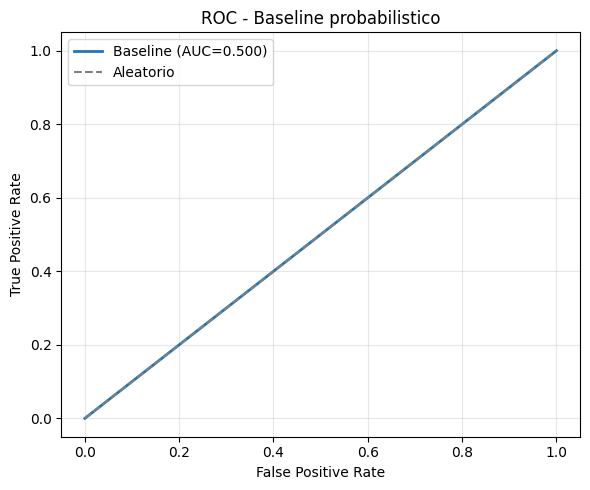

In [18]:
fpr_base, tpr_base, _ = roc_curve(y_test, proba_baseline)  # calcula pontos da ROC para baseline

plt.figure(figsize=(6, 5))  # cria figura ROC
plt.plot(fpr_base, tpr_base, label=f'Baseline (AUC={auc_baseline:.3f})', linewidth=2)  # plota curva baseline
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatorio')  # plota diagonal de referência
plt.title('ROC - Baseline probabilistico')  # título
plt.xlabel('False Positive Rate')  # eixo X
plt.ylabel('True Positive Rate')  # eixo Y
plt.legend()  # legenda
plt.grid(alpha=0.3)  # grade
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza


Leitura FP&A: baseline não separa bem clientes; agora entramos no primeiro modelo real.


### 4.2) Primeira logística (rápida) para gerar probabilidades

**O que vamos fazer:** treinar uma regressão logística com pré-processamento.

**Por que importa em FP&A:** logística é baseline forte e interpretável em governança.

**O que observar:** probabilidades previstas no TESTE (`y_proba_test_log`).


In [19]:
target = 'default_30p'  # define coluna alvo
num_features = [  # define variáveis numéricas de risco e perfil
    'selic', 'idade', 'renda_mensal', 'score_interno', 'valor_solicitado',
    'prazo_meses', 'utilizacao_limite', 'atraso_antes_30d', 'atraso_antes_60d',
    'taxa_mensal', 'parcela_mensal', 'pti', 'ead', 'lgd', 'loss_if_default', 'profit_if_good', 'mes_num'
]
cat_features = ['canal']  # define variável categórica

X_train = train[num_features + cat_features].copy()  # separa features de treino
X_test = test[num_features + cat_features].copy()  # separa features de teste

prep_log = ColumnTransformer(  # cria pré-processamento por tipo de coluna
    transformers=[
        ('num', StandardScaler(), num_features),  # padroniza variáveis numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),  # codifica categóricas em colunas binárias
    ]
)

pipe_log_intro = Pipeline(  # monta pipeline completo da logística
    steps=[
        ('prep', prep_log),  # etapa de preparação dos dados
        ('model', LogisticRegression(max_iter=2000, random_state=42)),  # etapa do modelo logístico
    ]
)

pipe_log_intro.fit(X_train, y_train)  # treina logística com dados de treino
y_proba_test_log = pipe_log_intro.predict_proba(X_test)[:, 1]  # gera probabilidade de default no teste

print('Primeiras 10 probabilidades (logística):')  # título do output
print(np.round(y_proba_test_log[:10], 4))  # mostra amostra das probabilidades previstas


Primeiras 10 probabilidades (logística):
[0.0387 0.0981 0.0447 0.0425 0.0325 0.0448 0.1052 0.2662 0.0503 0.0615]


### 4.2.1) ROC da logística

**O que observar:** AUC melhor que baseline e curva acima da diagonal.


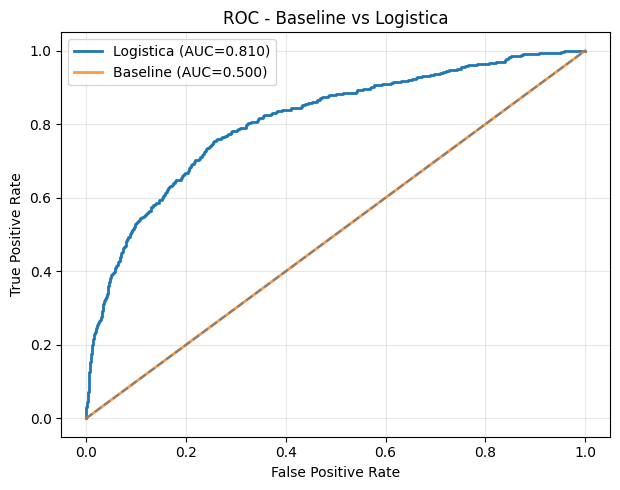

In [20]:
auc_log_intro = roc_auc_score(y_test, y_proba_test_log)  # calcula AUC da logística
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_test_log)  # calcula pontos ROC da logística

plt.figure(figsize=(6.3, 5))  # cria figura ROC
plt.plot(fpr_log, tpr_log, label=f'Logistica (AUC={auc_log_intro:.3f})', linewidth=2)  # plota ROC da logística
plt.plot(fpr_base, tpr_base, label=f'Baseline (AUC={auc_baseline:.3f})', linewidth=2, alpha=0.8)  # plota ROC baseline
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # diagonal de referência
plt.title('ROC - Baseline vs Logistica')  # título
plt.xlabel('False Positive Rate')  # eixo X
plt.ylabel('True Positive Rate')  # eixo Y
plt.legend()  # legenda
plt.grid(alpha=0.3)  # grade
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza


Leitura FP&A: quanto maior a área sob a curva (AUC), melhor a separação de risco no TESTE.


### 4.2.2) Histograma das probabilidades por classe real

**O que observar:** classe 1 (default) deve concentrar probabilidades maiores.


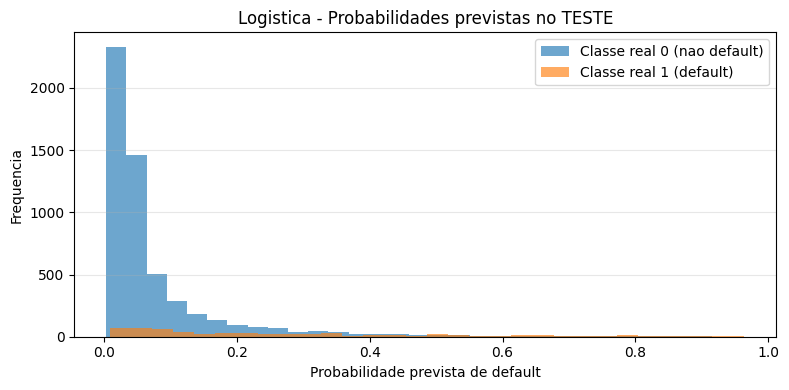

In [21]:
plt.figure(figsize=(8, 4))  # cria figura para comparar distribuições de probabilidade
plt.hist(y_proba_test_log[y_test.values == 0], bins=30, alpha=0.65, label='Classe real 0 (nao default)')  # distribuição dos bons
plt.hist(y_proba_test_log[y_test.values == 1], bins=30, alpha=0.65, label='Classe real 1 (default)')  # distribuição dos maus
plt.title('Logistica - Probabilidades previstas no TESTE')  # título
plt.xlabel('Probabilidade prevista de default')  # eixo X
plt.ylabel('Frequencia')  # eixo Y
plt.legend()  # legenda
plt.grid(axis='y', alpha=0.3)  # grade horizontal
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza


Leitura FP&A: quanto menor a sobreposição entre as duas distribuições, mais fácil definir política de cutoff.


### 4.2.3) Calendário de risco no TESTE

**O que observar:** variação temporal das probabilidades previstas.


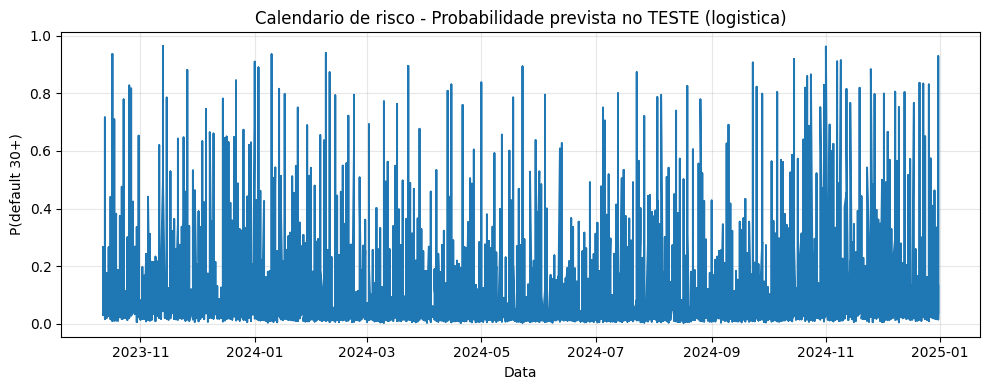

In [22]:
plt.figure(figsize=(10, 4))  # cria figura para série temporal de risco previsto
plt.plot(test['dt'], y_proba_test_log, color='#1f77b4', linewidth=1.4)  # plota risco previsto por mês no período de teste
plt.title('Calendario de risco - Probabilidade prevista no TESTE (logistica)')  # título
plt.xlabel('Data')  # eixo X
plt.ylabel('P(default 30+)')  # eixo Y
plt.grid(alpha=0.3)  # grade
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza


Leitura FP&A: picos de probabilidade sugerem meses com carteira mais arriscada.


### 4.3) Cutoff: 10%, 20% e 30%

**O que vamos fazer:** transformar probabilidade em decisão (0/1) com três cutoffs.

**Por que importa em FP&A:** cutoff define trade-off entre aprovar mais e controlar perdas.

**O que observar no output:** precision, recall, f1, FP, FN e custo total em R$ no TESTE.


In [23]:
cutoffs_fixos = [0.10, 0.20, 0.30]  # define cutoffs didáticos da aula
linhas_cutoff = []  # cria lista para armazenar métricas por cutoff
matrizes_cutoff = {}  # cria dicionário para guardar matrizes de confusão

for cutoff in cutoffs_fixos:  # percorre cada cutoff
    y_pred = (y_proba_test_log >= cutoff).astype(int)  # converte probabilidade em classe prevista
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()  # extrai componentes da matriz de confusão

    precision = precision_score(y_test, y_pred, zero_division=0)  # calcula precision no teste
    recall = recall_score(y_test, y_pred, zero_division=0)  # calcula recall no teste
    f1 = f1_score(y_test, y_pred, zero_division=0)  # calcula F1 no teste

    mask_fp = (y_test.values == 0) & (y_pred == 1)  # identifica falsos positivos (bom cliente recusado)
    mask_fn = (y_test.values == 1) & (y_pred == 0)  # identifica falsos negativos (mau cliente aprovado)

    custo_fp = test.loc[mask_fp, 'profit_if_good'].sum()  # soma lucro perdido por falsos positivos
    custo_fn = test.loc[mask_fn, 'loss_if_default'].sum()  # soma perda por falsos negativos
    custo_total = custo_fp + custo_fn  # soma custo econômico total

    linhas_cutoff.append({  # salva linha consolidada para o cutoff atual
        'cutoff': cutoff,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'FP': int(fp),
        'FN': int(fn),
        'custo_total_R$': float(custo_total),
    })

    matrizes_cutoff[cutoff] = np.array([[tn, fp], [fn, tp]])  # guarda matriz para plot posterior

cutoff_table_3 = pd.DataFrame(linhas_cutoff)  # transforma lista em DataFrame
cutoff_table_3


,cutoff,precision,recall,f1,FP,FN,custo_total_R$
0,0.1,0.272284,0.659359,0.385412,1045,202,3.986417e+06
1,0.2,0.391421,0.492411,0.436146,454,301,3.601819e+06
2,0.3,0.466970,0.345700,0.397287,234,388,3.878582e+06


### 4.3.1) Tabela consolidada dos 3 cutoffs

**O que observar:** como precisão, recall e custo mudam quando alteramos a política.


In [24]:
cutoff_table_3_ordenada = cutoff_table_3.sort_values('cutoff').copy()  # ordena tabela por cutoff crescente
cutoff_table_3_ordenada  # exibe tabela final dos três cenários


,cutoff,precision,recall,f1,FP,FN,custo_total_R$
0,0.1,0.272284,0.659359,0.385412,1045,202,3.986417e+06
1,0.2,0.391421,0.492411,0.436146,454,301,3.601819e+06
2,0.3,0.466970,0.345700,0.397287,234,388,3.878582e+06


### 4.3.2) Plot: 3 matrizes de confusão (lado a lado)

**O que observar:** mais cutoff geralmente reduz FP, mas aumenta FN.


/var/folders/l_/zp9ygrqn5z96g4zytffpdhn40000gn/T/ipykernel_69917/2077593693.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # ajusta espaçamento


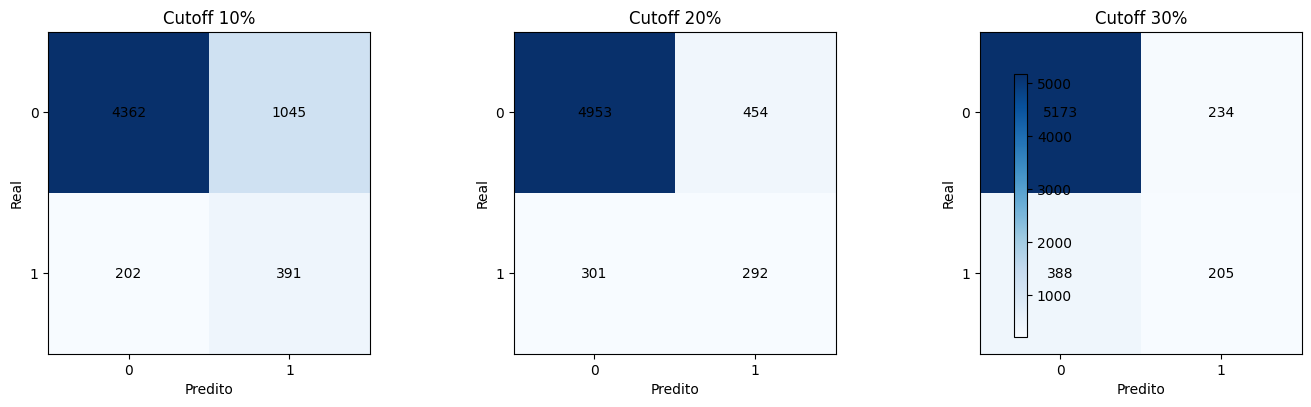

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3.8))  # cria figura com 3 painéis

for i, cutoff in enumerate(cutoffs_fixos):  # percorre cada cutoff para desenhar matriz
    cm = matrizes_cutoff[cutoff]  # seleciona matriz do cutoff atual
    ax = axes[i]  # seleciona eixo do painel atual

    im = ax.imshow(cm, cmap='Blues')  # desenha matriz em mapa de cor
    ax.set_title(f'Cutoff {int(cutoff*100)}%')  # título do painel
    ax.set_xlabel('Predito')  # rótulo eixo X
    ax.set_ylabel('Real')  # rótulo eixo Y
    ax.set_xticks([0, 1])  # define marcas do eixo X
    ax.set_yticks([0, 1])  # define marcas do eixo Y
    ax.set_xticklabels(['0', '1'])  # define nomes do eixo X
    ax.set_yticklabels(['0', '1'])  # define nomes do eixo Y

    for r in range(2):  # percorre linhas da matriz
        for c in range(2):  # percorre colunas da matriz
            ax.text(c, r, int(cm[r, c]), ha='center', va='center', color='black')  # anota valor da célula

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9)  # adiciona barra de cor compartilhada
plt.tight_layout()  # ajusta espaçamento
plt.show()  # renderiza


### 4.3.3) Plot: custo total em R$ por cutoff

**O que observar:** o melhor cutoff econômico pode não ser o melhor em F1.


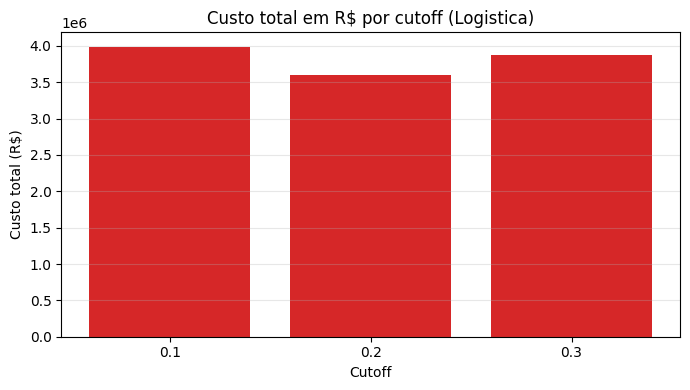

In [26]:
plt.figure(figsize=(7, 4))  # cria figura de comparação de custo
plt.bar(cutoff_table_3_ordenada['cutoff'].astype(str), cutoff_table_3_ordenada['custo_total_R$'], color='#d62728')  # plota barras de custo
plt.title('Custo total em R$ por cutoff (Logistica)')  # título
plt.xlabel('Cutoff')  # eixo X
plt.ylabel('Custo total (R$)')  # eixo Y
plt.grid(axis='y', alpha=0.3)  # grade horizontal
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza


### 4.4) Mensagem-chave

- **AUC** mede separação do modelo (independente de cutoff).
- **Precision/Recall/F1** mudam quando mudamos cutoff.
- **Cutoff é política de decisão** e deve ser escolhido por impacto econômico (R$).


## 5) Modelos (3 simples) e comparação justa

Agora vamos comparar, no mesmo teste temporal e mesmas features:
- LogisticRegression
- DecisionTreeClassifier
- GradientBoostingClassifier


### 5.1) Preparar `X` e `y` (features explícitas)

**O que vamos fazer:** definir colunas numéricas e categóricas de forma transparente.

**Por que importa em FP&A:** governança exige clareza sobre quais drivers entram no modelo.

**O que observar:** confirmação do total de features usadas.


In [27]:
target = 'default_30p'  # define alvo binário

num_features = [  # define colunas numéricas de entrada
    'selic', 'idade', 'renda_mensal', 'score_interno', 'valor_solicitado',
    'prazo_meses', 'utilizacao_limite', 'atraso_antes_30d', 'atraso_antes_60d',
    'taxa_mensal', 'parcela_mensal', 'pti', 'ead', 'lgd', 'loss_if_default', 'profit_if_good', 'mes_num'
]
cat_features = ['canal']  # define coluna categórica

X_train = train[num_features + cat_features].copy()  # cria matriz de treino
X_test = test[num_features + cat_features].copy()  # cria matriz de teste
y_train = train[target].copy()  # cria vetor alvo treino
y_test = test[target].copy()  # cria vetor alvo teste

print('Features numericas:', len(num_features))  # imprime total numérico
print('Features categoricas:', len(cat_features))  # imprime total categórico
print('Total de features de entrada:', len(num_features) + len(cat_features))  # imprime total de colunas brutas


Features numericas: 17
Features categoricas: 1
Total de features de entrada: 18


### 5.2) Definir pré-processamento e 3 modelos

**O que vamos fazer:** montar pipelines para garantir processamento consistente.

**O que observar:** nomes dos modelos que serão comparados.


In [28]:
prep = ColumnTransformer(  # cria bloco de tratamento de variáveis por tipo
    transformers=[
        ('num', StandardScaler(), num_features),  # padroniza variáveis numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),  # codifica variáveis categóricas
    ]
)

model_specs = {  # define os três modelos solicitados para comparação
    'LogisticRegression': LogisticRegression(max_iter=2000, random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=5, random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
}

print('Modelos da comparacao:', list(model_specs.keys()))  # confirma modelos usados


Modelos da comparacao: ['LogisticRegression', 'DecisionTreeClassifier', 'GradientBoostingClassifier']


### 5.3) Treinar e medir AUC no TESTE

**O que vamos fazer:** treinar cada pipeline e medir AUC no mesmo período de teste.

**Por que importa em FP&A:** comparação justa requer mesmo recorte temporal.

**O que observar:** tabela ordenada por AUC.


In [29]:
pipelines = {}  # dicionário para armazenar pipelines treinados
proba_models = {}  # dicionário para armazenar probabilidades no teste
rows_results = []  # lista para montar tabela de resultados

for nome, modelo in model_specs.items():  # percorre cada modelo
    pipe = Pipeline(  # cria pipeline completo para o modelo atual
        steps=[
            ('prep', prep),  # etapa de pré-processamento
            ('model', modelo),  # etapa do classificador
        ]
    )

    pipe.fit(X_train, y_train)  # treina pipeline no conjunto de treino
    proba_test = pipe.predict_proba(X_test)[:, 1]  # calcula probabilidade da classe 1 no teste
    auc_test = roc_auc_score(y_test, proba_test)  # calcula AUC no teste

    pipelines[nome] = pipe  # guarda pipeline treinado
    proba_models[nome] = proba_test  # guarda probabilidades previstas
    rows_results.append({'modelo': nome, 'auc_teste': auc_test})  # guarda linha de resultado

results_models = pd.DataFrame(rows_results).sort_values('auc_teste', ascending=False).reset_index(drop=True)  # cria ranking por AUC
results_models


,modelo,auc_teste
0,LogisticRegression,0.810293
1,GradientBoostingClassifier,0.804175
2,DecisionTreeClassifier,0.789365


### 5.4) Plot: ROC das 3 curvas no mesmo gráfico

**O que observar:** curva mais próxima do canto superior esquerdo tende a ter melhor AUC.


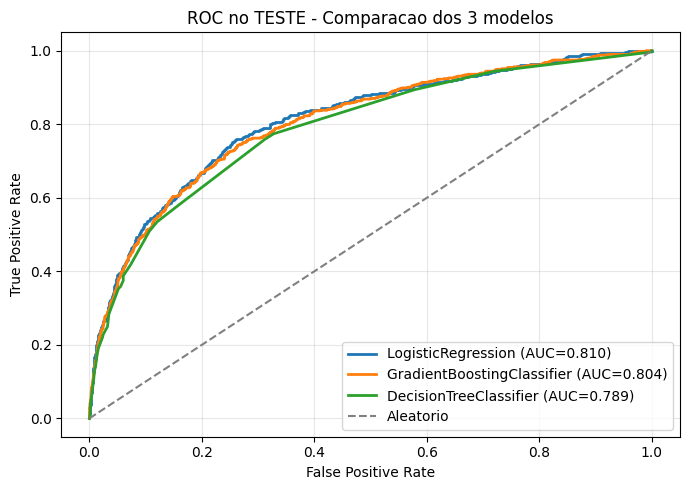

In [30]:
plt.figure(figsize=(7, 5))  # cria figura ROC comparativa

for nome in results_models['modelo']:  # percorre modelos na ordem do ranking
    fpr, tpr, _ = roc_curve(y_test, proba_models[nome])  # calcula pontos da curva ROC
    auc_val = roc_auc_score(y_test, proba_models[nome])  # calcula AUC do modelo atual
    plt.plot(fpr, tpr, linewidth=2, label=f'{nome} (AUC={auc_val:.3f})')  # plota curva do modelo

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatorio')  # diagonal de referência
plt.title('ROC no TESTE - Comparacao dos 3 modelos')  # título
plt.xlabel('False Positive Rate')  # eixo X
plt.ylabel('True Positive Rate')  # eixo Y
plt.legend()  # legenda
plt.grid(alpha=0.3)  # grade
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza


### 5.5) Plot: AUC por modelo (barras)

**O que observar:** diferença de separação entre os modelos no TESTE.


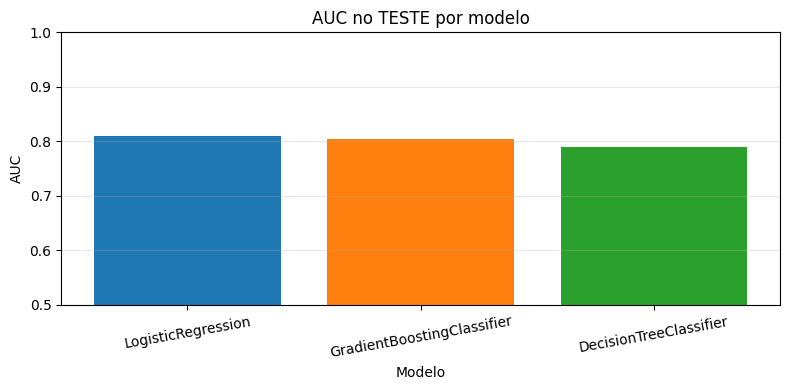

In [31]:
plt.figure(figsize=(8, 4))  # cria figura de barras para AUC
plt.bar(results_models['modelo'], results_models['auc_teste'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])  # plota AUC por modelo
plt.title('AUC no TESTE por modelo')  # título
plt.xlabel('Modelo')  # eixo X
plt.ylabel('AUC')  # eixo Y
plt.ylim(0.5, 1.0)  # limita eixo Y para foco na faixa de interesse
plt.grid(axis='y', alpha=0.3)  # grade horizontal
plt.xticks(rotation=10)  # ajusta rotação dos rótulos do eixo X
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza


### 5.6) Governança: coeficientes da Logística (top positivos e negativos)

**O que vamos fazer:** visualizar direção dos efeitos na logística.

**O que observar:** coeficientes positivos aumentam risco previsto; negativos reduzem.


In [32]:
log_pipe = pipelines['LogisticRegression']  # recupera pipeline logístico treinado
log_prep = log_pipe.named_steps['prep']  # recupera etapa de pré-processamento da logística
log_model = log_pipe.named_steps['model']  # recupera modelo logístico

feature_names_log = log_prep.get_feature_names_out()  # extrai nomes das features após transformação
coef_values = log_model.coef_[0]  # extrai coeficientes da classe positiva
coef_series = pd.Series(coef_values, index=feature_names_log).sort_values()  # cria série ordenada por sinal e magnitude

top_neg = coef_series.head(8)  # seleciona 8 coeficientes mais negativos
top_pos = coef_series.tail(8)  # seleciona 8 coeficientes mais positivos


### 5.6.1) Plot: coeficientes da logística

**Por que importa em FP&A:** ajuda narrativa com comitê de crédito e auditoria.


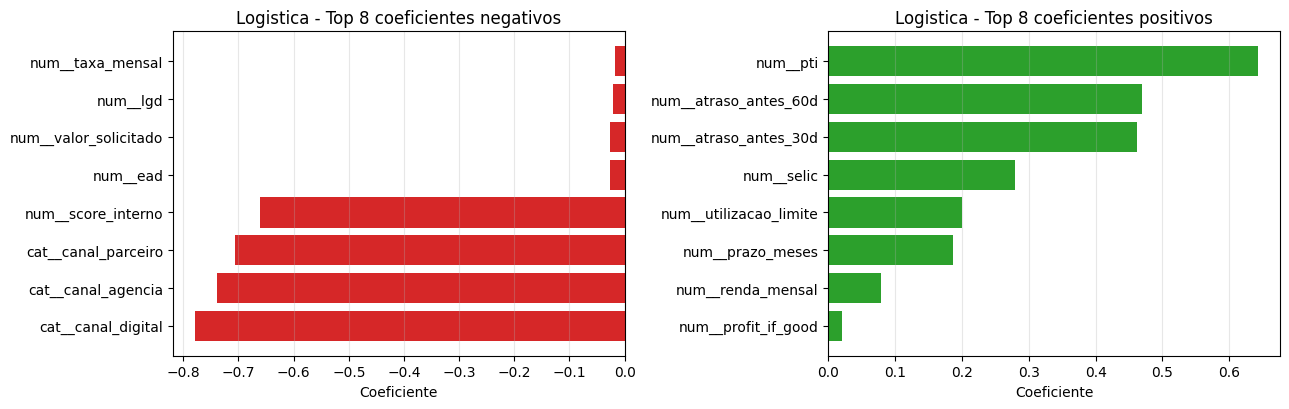

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4.2))  # cria figura com dois painéis

axes[0].barh(top_neg.index, top_neg.values, color='#d62728')  # plota coeficientes negativos
axes[0].set_title('Logistica - Top 8 coeficientes negativos')  # título painel esquerdo
axes[0].set_xlabel('Coeficiente')  # eixo X painel esquerdo
axes[0].grid(axis='x', alpha=0.3)  # grade painel esquerdo

axes[1].barh(top_pos.index, top_pos.values, color='#2ca02c')  # plota coeficientes positivos
axes[1].set_title('Logistica - Top 8 coeficientes positivos')  # título painel direito
axes[1].set_xlabel('Coeficiente')  # eixo X painel direito
axes[1].grid(axis='x', alpha=0.3)  # grade painel direito

plt.tight_layout()  # ajusta layout
plt.show()  # renderiza


Leitura FP&A: na logística, o sinal do coeficiente ajuda a discutir direção do risco. Ainda assim, coeficiente não prova causalidade.


### 5.7) Governança: feature importance da Árvore

**O que observar:** ranking de variáveis que mais reduziram erro nos splits da árvore.


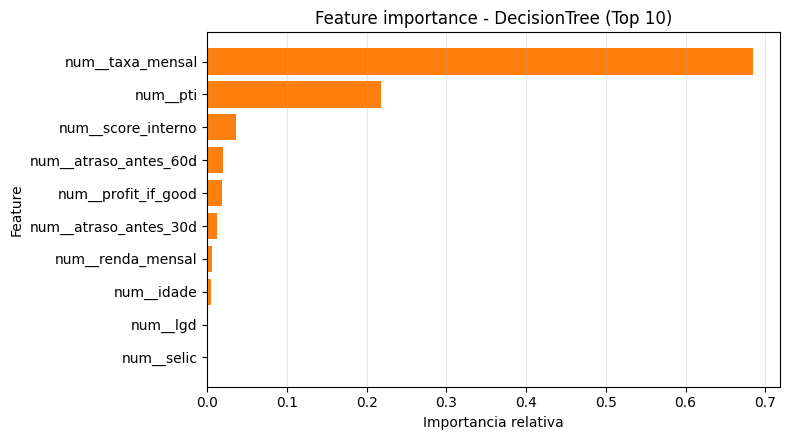

In [34]:
tree_pipe = pipelines['DecisionTreeClassifier']  # recupera pipeline da árvore
tree_prep = tree_pipe.named_steps['prep']  # recupera pré-processamento da árvore
tree_model = tree_pipe.named_steps['model']  # recupera classificador árvore

feature_names_tree = tree_prep.get_feature_names_out()  # extrai nomes das features transformadas
tree_importance = pd.Series(tree_model.feature_importances_, index=feature_names_tree).sort_values(ascending=False)  # calcula ranking de importância

top_tree = tree_importance.head(10).sort_values()  # seleciona top 10 e ordena para barra horizontal

plt.figure(figsize=(8, 4.5))  # cria figura de importância da árvore
plt.barh(top_tree.index, top_tree.values, color='#ff7f0e')  # plota barras horizontais
plt.title('Feature importance - DecisionTree (Top 10)')  # título
plt.xlabel('Importancia relativa')  # eixo X
plt.ylabel('Feature')  # eixo Y
plt.grid(axis='x', alpha=0.3)  # grade no eixo X
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza


### 5.8) Governança: feature importance do GBM

**O que observar:** comparação com a árvore para entender estabilidade do ranking.


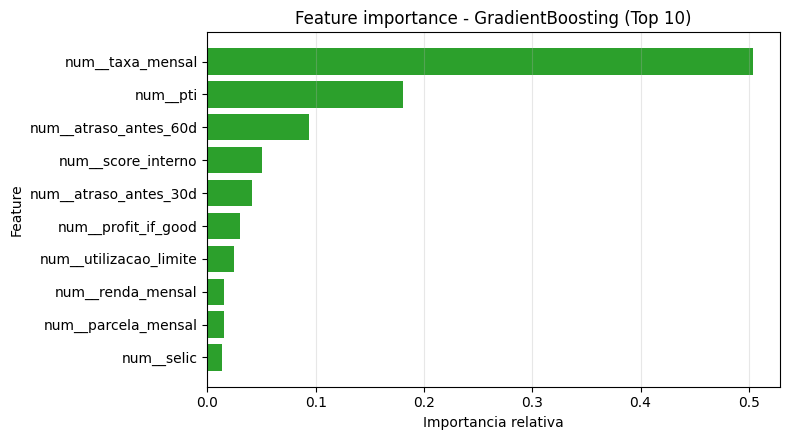

In [35]:
gbm_pipe = pipelines['GradientBoostingClassifier']  # recupera pipeline do GBM
gbm_prep = gbm_pipe.named_steps['prep']  # recupera pré-processamento do GBM
gbm_model = gbm_pipe.named_steps['model']  # recupera classificador GBM

feature_names_gbm = gbm_prep.get_feature_names_out()  # extrai nomes das features transformadas
gbm_importance = pd.Series(gbm_model.feature_importances_, index=feature_names_gbm).sort_values(ascending=False)  # calcula ranking de importância

top_gbm = gbm_importance.head(10).sort_values()  # seleciona top 10 e ordena para barra horizontal

plt.figure(figsize=(8, 4.5))  # cria figura de importância do GBM
plt.barh(top_gbm.index, top_gbm.values, color='#2ca02c')  # plota barras horizontais
plt.title('Feature importance - GradientBoosting (Top 10)')  # título
plt.xlabel('Importancia relativa')  # eixo X
plt.ylabel('Feature')  # eixo Y
plt.grid(axis='x', alpha=0.3)  # grade no eixo X
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza


Leitura FP&A: importance ajuda priorização de drivers, mas **não prova causalidade**. Variáveis correlacionadas podem trocar posição no ranking.


## 6) Demo FP&A: tabela cutoff x custo total (Logística vs GBM)

Agora vamos transformar o score em política com grid de cutoffs de 5% a 50%.


### 6.1) Construir grade de cutoffs para Logística e GBM

**O que vamos fazer:** calcular métricas e custo para cada cutoff.

**O que observar:** como custo e aprovação mudam com a política.


In [36]:
cutoff_grid = np.arange(0.05, 0.51, 0.05)  # cria grade de cutoffs de 5% a 50%
rows_grid = []  # cria lista para armazenar resultados de todos os cutoffs

for nome_modelo in ['LogisticRegression', 'GradientBoostingClassifier']:  # percorre apenas os dois modelos da demo
    proba = proba_models[nome_modelo]  # recupera probabilidades previstas no teste

    for cutoff in cutoff_grid:  # percorre cada cutoff da grade
        y_pred = (proba >= cutoff).astype(int)  # converte probabilidade em classe prevista
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()  # extrai matriz de confusão

        precision = precision_score(y_test, y_pred, zero_division=0)  # calcula precision no teste
        recall = recall_score(y_test, y_pred, zero_division=0)  # calcula recall no teste
        f1 = f1_score(y_test, y_pred, zero_division=0)  # calcula F1 no teste

        mask_fp = (y_test.values == 0) & (y_pred == 1)  # identifica falsos positivos
        mask_fn = (y_test.values == 1) & (y_pred == 0)  # identifica falsos negativos

        custo_fp = test.loc[mask_fp, 'profit_if_good'].sum()  # soma lucro perdido por FP
        custo_fn = test.loc[mask_fn, 'loss_if_default'].sum()  # soma perda por FN
        custo_total = custo_fp + custo_fn  # calcula custo total econômico

        taxa_aprovacao = (y_pred == 0).mean()  # calcula proporção de clientes aprovados (predição 0)

        rows_grid.append({  # salva linha consolidada para tabela cutoff x custo
            'modelo': nome_modelo,
            'cutoff': cutoff,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'FP': int(fp),
            'FN': int(fn),
            'custo_total_R$': float(custo_total),
            'taxa_aprovacao': float(taxa_aprovacao),
        })

grid_results = pd.DataFrame(rows_grid)  # transforma lista em DataFrame

grid_log = grid_results[grid_results['modelo'] == 'LogisticRegression'].copy()  # filtra resultados da logística
grid_gbm = grid_results[grid_results['modelo'] == 'GradientBoostingClassifier'].copy()  # filtra resultados do GBM


### 6.1.1) Top 5 cutoffs (menor custo) — Logística

**O que observar:** melhor trade-off econômico dentro da grade para o modelo logístico.


In [37]:
grid_log.nsmallest(5, 'custo_total_R$')  # mostra os 5 melhores cutoffs por menor custo na logística


,modelo,cutoff,precision,recall,f1,FP,FN,custo_total_R$,taxa_aprovacao
3,LogisticRegression,0.20,0.391421,0.492411,0.436146,454,301,3.601819e+06,0.875667
2,LogisticRegression,0.15,0.331663,0.558179,0.416091,667,262,3.718651e+06,0.833667
4,LogisticRegression,0.25,0.427826,0.414840,0.421233,329,347,3.739050e+06,0.904167
5,LogisticRegression,0.30,0.466970,0.345700,0.397287,234,388,3.878582e+06,0.926833
1,LogisticRegression,0.10,0.272284,0.659359,0.385412,1045,202,3.986417e+06,0.760667


### 6.1.2) Top 5 cutoffs (menor custo) — GBM

**O que observar:** melhor trade-off econômico dentro da grade para o GBM.


In [38]:
grid_gbm.nsmallest(5, 'custo_total_R$')  # mostra os 5 melhores cutoffs por menor custo no GBM


,modelo,cutoff,precision,recall,f1,FP,FN,custo_total_R$,taxa_aprovacao
14,GradientBoostingClassifier,0.25,0.423280,0.404722,0.413793,327,353,3.723236e+06,0.905500
13,GradientBoostingClassifier,0.20,0.379730,0.473862,0.421605,459,312,3.727802e+06,0.876667
12,GradientBoostingClassifier,0.15,0.331622,0.544688,0.412253,651,270,3.842112e+06,0.837667
15,GradientBoostingClassifier,0.30,0.460241,0.322091,0.378968,224,402,3.915310e+06,0.930833
16,GradientBoostingClassifier,0.35,0.512422,0.278246,0.360656,157,428,3.924814e+06,0.946333


### 6.1.3) Plot: custo total em R$ vs cutoff

**O que observar:** o cutoff ótimo por custo pode ser diferente entre modelos.


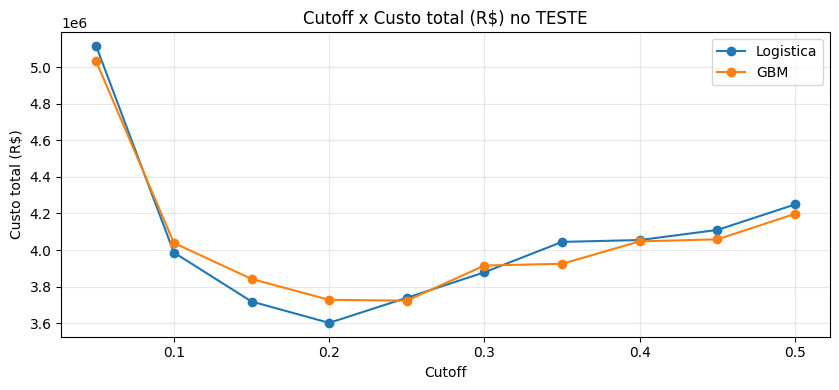

In [39]:
plt.figure(figsize=(8.5, 4))  # cria figura de custo por cutoff
plt.plot(grid_log['cutoff'], grid_log['custo_total_R$'], marker='o', label='Logistica')  # plota custo da logística
plt.plot(grid_gbm['cutoff'], grid_gbm['custo_total_R$'], marker='o', label='GBM')  # plota custo do GBM
plt.title('Cutoff x Custo total (R$) no TESTE')  # título
plt.xlabel('Cutoff')  # eixo X
plt.ylabel('Custo total (R$)')  # eixo Y
plt.legend()  # legenda
plt.grid(alpha=0.3)  # grade
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza


### 6.1.4) Plot: F1 vs cutoff

**O que observar:** F1 também depende da política de corte; não é fixo do modelo.


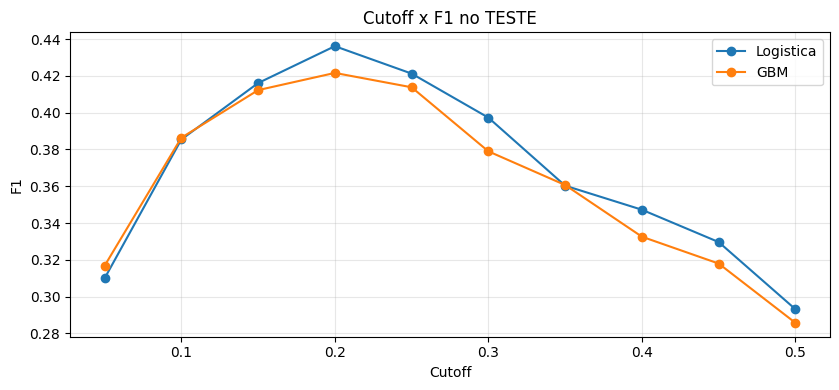

In [40]:
plt.figure(figsize=(8.5, 4))  # cria figura de F1 por cutoff
plt.plot(grid_log['cutoff'], grid_log['f1'], marker='o', label='Logistica')  # plota F1 da logística
plt.plot(grid_gbm['cutoff'], grid_gbm['f1'], marker='o', label='GBM')  # plota F1 do GBM
plt.title('Cutoff x F1 no TESTE')  # título
plt.xlabel('Cutoff')  # eixo X
plt.ylabel('F1')  # eixo Y
plt.legend()  # legenda
plt.grid(alpha=0.3)  # grade
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza


### 6.1.5) Plot: FN e FP vs cutoff

**O que observar:** subir cutoff tende a reduzir FP e aumentar FN (trade-off clássico).


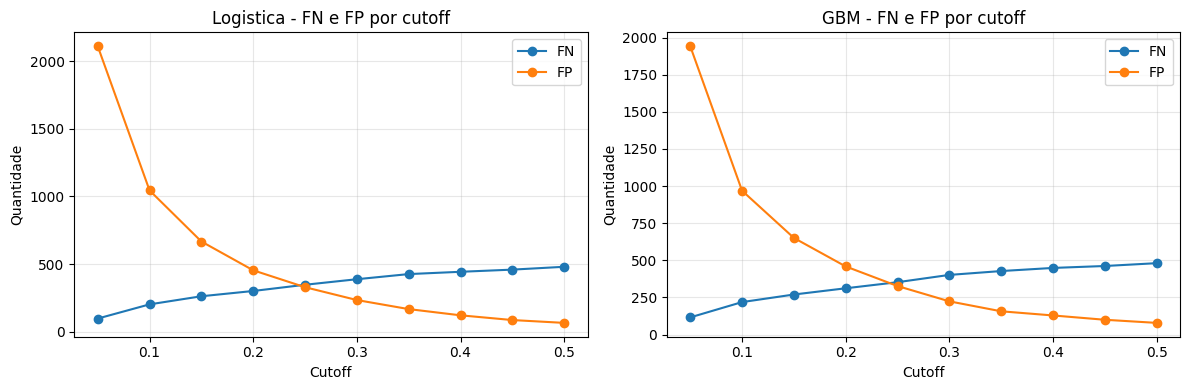

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)  # cria figura com dois painéis

axes[0].plot(grid_log['cutoff'], grid_log['FN'], marker='o', label='FN')  # plota FN da logística
axes[0].plot(grid_log['cutoff'], grid_log['FP'], marker='o', label='FP')  # plota FP da logística
axes[0].set_title('Logistica - FN e FP por cutoff')  # título painel 1
axes[0].set_xlabel('Cutoff')  # eixo X painel 1
axes[0].set_ylabel('Quantidade')  # eixo Y painel 1
axes[0].legend()  # legenda painel 1
axes[0].grid(alpha=0.3)  # grade painel 1

axes[1].plot(grid_gbm['cutoff'], grid_gbm['FN'], marker='o', label='FN')  # plota FN do GBM
axes[1].plot(grid_gbm['cutoff'], grid_gbm['FP'], marker='o', label='FP')  # plota FP do GBM
axes[1].set_title('GBM - FN e FP por cutoff')  # título painel 2
axes[1].set_xlabel('Cutoff')  # eixo X painel 2
axes[1].set_ylabel('Quantidade')  # eixo Y painel 2
axes[1].legend()  # legenda painel 2
axes[1].grid(alpha=0.3)  # grade painel 2

plt.tight_layout()  # ajusta layout
plt.show()  # renderiza


### 6.2) Conclusão da demo cutoff x custo

**O que vamos fazer:** identificar o cutoff de menor custo para cada modelo.

**O que observar:** melhor AUC não garante automaticamente melhor custo com qualquer cutoff.


In [42]:
best_log = grid_log.loc[grid_log['custo_total_R$'].idxmin()]  # seleciona melhor cutoff economico da logistica
best_gbm = grid_gbm.loc[grid_gbm['custo_total_R$'].idxmin()]  # seleciona melhor cutoff economico do GBM

print('Melhor Logistica (menor custo):')  # titulo de leitura da logistica
print(best_log[['cutoff', 'precision', 'recall', 'f1', 'FP', 'FN', 'custo_total_R$', 'taxa_aprovacao']])  # imprime linha resumo logistica

print('')  # imprime linha em branco para separar blocos no output
print('Melhor GBM (menor custo):')  # titulo de leitura do GBM
print(best_gbm[['cutoff', 'precision', 'recall', 'f1', 'FP', 'FN', 'custo_total_R$', 'taxa_aprovacao']])  # imprime linha resumo GBM


Melhor Logistica (menor custo):
cutoff                       0.2
precision               0.391421
recall                  0.492411
f1                      0.436146
FP                           454
FN                           301
custo_total_R$    3601819.020456
taxa_aprovacao          0.875667
Name: 3, dtype: object

Melhor GBM (menor custo):
cutoff                      0.25
precision                0.42328
recall                  0.404722
f1                      0.413793
FP                           327
FN                           353
custo_total_R$    3723235.969954
taxa_aprovacao            0.9055
Name: 14, dtype: object


Leitura FP&A: o cutoff ótimo muda com a função de custo. O melhor modelo é o que entrega melhor resultado econômico no contexto da política escolhida.


## 7) Conclusões Executivas

- **Logística:** baseline forte e interpretável; ótima para governança e comitê.
- **Árvore:** regras visuais didáticas; pode overfitar se a profundidade for alta.
- **GBM:** costuma melhorar separação e potencial de custo; exige governança adicional.
- **AUC é separação (modelo)**, **cutoff é decisão (política)**, **custo em R$ é payoff**.
- **Feature importance** ajuda narrativa, mas não comprova causalidade.
- Recomendação prática: iniciar com logística, comparar com GBM e escolher cutoff por custo.


## 8) Checklist FP&A (1 minuto)

- Baseline obrigatório (probabilidade constante e/ou logística simples)
- Split temporal (sem embaralhar)
- Métricas no TESTE: AUC (modelo) + Precision/Recall/F1 (cutoff) + custo em R$
- Governança: interpretabilidade, documentação e rastreabilidade
- Monitoramento: drift, mudança de regime macro e recalibração de cutoff
